<a href="https://colab.research.google.com/github/yananma/5_programs_per_day/blob/master/0517.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 9.1 图像增广

In [4]:
!git clone https://github.com/d2l-ai/d2l-zh.git

Cloning into 'd2l-zh'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15702 (delta 9), reused 8 (delta 4), pack-reused 15685
Receiving objects: 100% (15702/15702), 159.56 MiB | 40.42 MiB/s, done.
Resolving deltas: 100% (11132/11132), done.


In [0]:
!mkdir ../img

In [0]:
!cp ./d2l-zh/img/cat1.jpg ../img/

In [0]:
!pip install mxnet-cu100 d2lzh

In [0]:
%matplotlib inline 
import d2lzh as d2l 
import mxnet as mx 
from mxnet import autograd, gluon, image, init, nd 
from mxnet.gluon import data as gdata, loss as gloss, utils as gutils 
import sys 
import time 

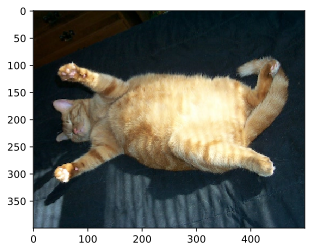

In [7]:
d2l.set_figsize(figsize=(5.6, 4))
img = image.imread('../img/cat1.jpg')
d2l.plt.imshow((img.asnumpy()))

In [0]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j].asnumpy())
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes 

In [0]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

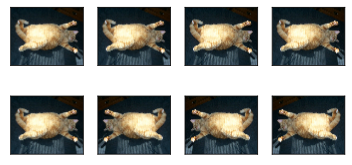

In [10]:
apply(img, gdata.vision.transforms.RandomFlipLeftRight())

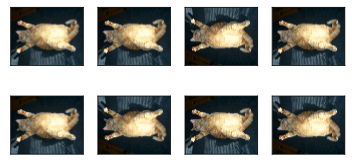

In [11]:
apply(img, gdata.vision.transforms.RandomFlipTopBottom())

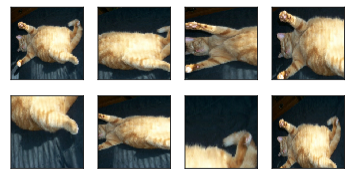

In [12]:
shape_aug = gdata.vision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

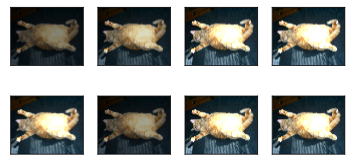

In [13]:
apply(img, gdata.vision.transforms.RandomBrightness(0.5))

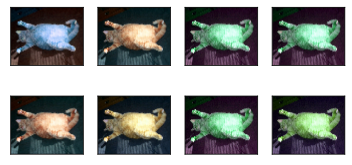

In [14]:
apply(img, gdata.vision.transforms.RandomHue(0.5))

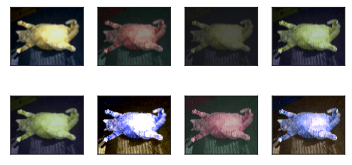

In [15]:
color_aug = gdata.vision.transforms.RandomColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
)
apply(img, color_aug)

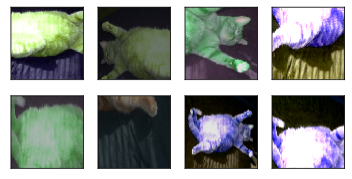

In [16]:
augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomFlipLeftRight(), color_aug, shape_aug
])
apply(img, augs)

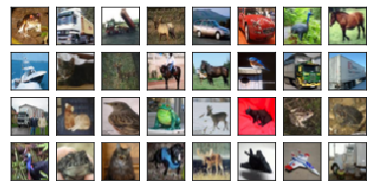

In [17]:
show_images(gdata.vision.CIFAR10(train=True)[0:32][0], 4, 8, scale=0.8);

In [0]:
flip_aug = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomFlipLeftRight(), 
    gdata.vision.transforms.ToTensor()
])
no_aug = gdata.vision.transforms.Compose([
    gdata.vision.transforms.ToTensor()
])

In [0]:
num_workers = 4 
def load_cifar10(is_train, augs, batch_size):
    return gdata.DataLoader(
        gdata.vision.CIFAR10(train=is_train).transform_first(augs), 
        batch_size=batch_size, shuffle=is_train, num_workers=num_workers
    )

In [0]:
def try_all_gpus():
    ctxes = []
    try:
        for i in range(16):
            ctx = mx.gpu(i)
            _ = nd.array([0], ctx=ctx)
            ctxes.append(ctx)
    except mx.base.MXNetError:
        pass 
    if not ctxes:
        ctxes = [mx.cpu()]
    return ctxes 

In [0]:
def _get_batch(batch, ctx):
    features, labels = batch 
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    return (gutils.split_and_load(features, ctx), 
        gutils.split_and_load(labels, ctx), features.shape[0])

In [0]:
def evaluate_accuracy(data_iter, net, ctx=[mx.cpu()]):
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    acc_sum, n = nd.array([0]), 0 
    for batch in data_iter:
        features, labels, _ = _get_batch(batch, ctx)
        for X, y in zip(features, labels):
            y = y.astype('float32')
            acc_sum += (net(X).argmax(axis=1) == y).sum().copyto(mx.cpu())
            n += y.size 
        acc_sum.wait_to_read()
    return acc_sum.asscalar() / n 

In [0]:
def train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs):
    print('training on', ctx)
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, m, start = 0.0, 0.0, 0, 0, time.time()
        for i, batch in enumerate(train_iter):
            Xs, ys, batch_size = _get_batch(batch, ctx)
            ls = []
            with autograd.record():
                y_hats = [net(X) for X in Xs]
                ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            train_l_sum += sum([l.sum().asscalar() for l in ls])
            n += sum([l.size for l in ls])
            train_acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar() 
                for y_hat, y in zip(y_hats, ys)])
            m += sum([y.size for y in ys])
        test_acc = evaluate_accuracy(test_iter, net, ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, ' 'time %.1f sec' 
              % (epoch + 1, train_l_sum / n, train_acc_sum / m, test_acc, time.time() - start))


In [0]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, ctx, net = 256, try_all_gpus(), d2l.resnet18(10)
    net.initialize(ctx=ctx, init=init.Xavier())
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    loss = gloss.SoftmaxCrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=10)

In [33]:
train_with_data_aug(flip_aug, no_aug)

training on [gpu(0)]
epoch 1, loss 1.3648, train acc 0.512, test acc 0.619, time 28.4 sec
epoch 2, loss 0.8070, train acc 0.714, test acc 0.655, time 26.9 sec
epoch 3, loss 0.5959, train acc 0.792, test acc 0.785, time 27.0 sec
epoch 4, loss 0.4691, train acc 0.837, test acc 0.758, time 27.0 sec
epoch 5, loss 0.3966, train acc 0.861, test acc 0.799, time 27.0 sec
epoch 6, loss 0.3281, train acc 0.886, test acc 0.832, time 27.4 sec
epoch 7, loss 0.2717, train acc 0.905, test acc 0.832, time 26.6 sec
epoch 8, loss 0.2332, train acc 0.919, test acc 0.802, time 26.9 sec
epoch 9, loss 0.1947, train acc 0.933, test acc 0.821, time 26.7 sec
epoch 10, loss 0.1608, train acc 0.945, test acc 0.839, time 26.7 sec


In [0]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, ctx, net = 256, try_all_gpus(), d2l.resnet18(10)
    net.initialize(ctx=ctx, init=init.Xavier())
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
    loss = gloss.SoftmaxCrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=5)

In [35]:
train_with_data_aug(flip_aug, no_aug)

training on [gpu(0)]
epoch 1, loss 1.3923, train acc 0.504, test acc 0.514, time 27.2 sec
epoch 2, loss 0.8210, train acc 0.709, test acc 0.634, time 26.8 sec
epoch 3, loss 0.6142, train acc 0.785, test acc 0.765, time 27.9 sec
epoch 4, loss 0.4887, train acc 0.831, test acc 0.797, time 26.9 sec
epoch 5, loss 0.4012, train acc 0.861, test acc 0.811, time 26.8 sec


## 9.2 微调

In [0]:
%matplotlib inline 
import d2lzh as d2l 
from mxnet import gluon, init, nd 
from mxnet.gluon import data as gdata, loss as gloss, model_zoo 
from mxnet.gluon import utils as gutils 
import os 
import zipfile 

In [0]:
!mkdir ../data

In [40]:
data_dir = '../data'
base_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/'
fname = gutils.download(
    base_url + 'gluon/dataset/hotdog.zip', 
    path=data_dir, sha1_hash='fba480ffa8aa7e0febbb511d181409f899b9baa5'
)
with zipfile.ZipFile(fname, 'r') as z:
    z.extractall(data_dir)

In [0]:
train_imgs = gdata.vision.ImageFolderDataset(os.path.join(data_dir, 'hotdog/train'))
test_imgs = gdata.vision.ImageFolderDataset(os.path.join(data_dir, 'hotdog/test'))


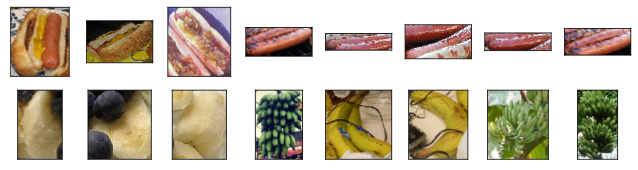

In [45]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i -1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [0]:
normalize = gdata.vision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomResizedCrop(224), 
    gdata.vision.transforms.RandomFlipLeftRight(), 
    gdata.vision.transforms.ToTensor(), 
    normalize
])

test_augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.Resize(256), 
    gdata.vision.transforms.CenterCrop(224), 
    gdata.vision.transforms.ToTensor(), 
    normalize                                             
])

In [47]:
pretrained_net = model_zoo.vision.resnet18_v2(pretrained=True)

In [48]:
pretrained_net.output

Dense(512 -> 1000, linear)

In [0]:
finetune_net = model_zoo.vision.resnet18_v2(classes=2)
finetune_net.features = pretrained_net.features 
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

In [0]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5):
    train_iter = gdata.DataLoader(train_imgs.transform_first(train_augs), batch_size, shuffle=True)
    test_iter = gdata.DataLoader(test_imgs.transform_first(test_augs), batch_size)
    ctx = d2l.try_all_gpus()
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gloss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':learning_rate, 'wd':0.001})
    d2l.train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs)

In [55]:
train_fine_tuning(finetune_net, 0.01)

training on [gpu(0)]
epoch 1, loss 3.3980, train acc 0.667, test acc 0.917, time 15.3 sec
epoch 2, loss 0.4166, train acc 0.906, test acc 0.899, time 12.2 sec
epoch 3, loss 0.2772, train acc 0.915, test acc 0.939, time 12.0 sec
epoch 4, loss 0.2448, train acc 0.913, test acc 0.914, time 12.0 sec
epoch 5, loss 0.5003, train acc 0.895, test acc 0.938, time 12.1 sec


In [57]:
scratch_net = model_zoo.vision.resnet18_v2(classes=2)
scratch_net.initialize(init=init.Xavier())
train_fine_tuning(scratch_net, 0.1)

training on [gpu(0)]
epoch 1, loss 0.6752, train acc 0.715, test acc 0.811, time 12.3 sec
epoch 2, loss 0.4283, train acc 0.809, test acc 0.840, time 12.1 sec
epoch 4, loss 0.3729, train acc 0.838, test acc 0.851, time 12.1 sec
epoch 5, loss 0.3329, train acc 0.870, test acc 0.799, time 12.1 sec
